In [0]:
import torchvision
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from torch import optim


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
class To3Channels(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        if sample.shape[0] < 3:
            sample = torch.squeeze(sample)
            sample = torch.stack([sample, sample,sample], 0)

        return sample

In [70]:
transformer =  torchvision.transforms.Compose(
    [torchvision.transforms.Resize(224),
     torchvision.transforms.ToTensor(),
     To3Channels(),
     torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

CIFAR10_train = torchvision.datasets.CIFAR10("../datasets/CIFAR10/", train=True, transform=transformer, target_transform=None, download=True)
CIFAR100_train = torchvision.datasets.CIFAR100("../datasets/CIFAR100/", train=True, transform=transformer, target_transform=None, download=True)
FashionMNIST_train = torchvision.datasets.FashionMNIST("../datasets/FashionMNIST/", train=True, transform=transformer, target_transform=None, download=True)




CIFAR10_test = torchvision.datasets.CIFAR10("../datasets/CIFAR10/", train=False, transform=transformer, target_transform=None, download=True)
CIFAR100_test = torchvision.datasets.CIFAR100("../datasets/CIFAR100/", train=False, transform=transformer, target_transform=None, download=True)
FashionMNIST_test = torchvision.datasets.FashionMNIST("../datasets/FashionMNIST/", train=False, transform=transformer, target_transform=None, download=True)






Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [0]:
def get_loaders(dataset = "CIFAR10"):
    train_loader = None
    test_loader = None
    labels_num = None

    if dataset == "CIFAR10":
        train_loader = torch.utils.data.DataLoader(CIFAR10_train, batch_size=128,
                                          shuffle=True, num_workers=2)
        test_loader = torch.utils.data.DataLoader(CIFAR10_test, batch_size=128,
                                          shuffle=True, num_workers=2)
        labels_num = 10#len(set(CIFAR10_train.train_labels))
    elif dataset == "CIFAR100":
        train_loader = torch.utils.data.DataLoader(CIFAR100_train, batch_size=64,
                                                   shuffle=True, num_workers=2)
        test_loader = torch.utils.data.DataLoader(CIFAR100_test, batch_size=64,
                                                  shuffle=True, num_workers=2)
        labels_num = 100

    elif dataset == "FASHION_MNIST":
        train_loader = torch.utils.data.DataLoader(FashionMNIST_train, batch_size=128,
                                                   shuffle=True, num_workers=2)
        test_loader = torch.utils.data.DataLoader(FashionMNIST_test, batch_size=128,
                                                  shuffle=True, num_workers=2)
        labels_num = len(set(FashionMNIST_train.train_labels))


    return train_loader,test_loader,labels_num

In [0]:
class AlexNet(nn.Module):

    def __init__(self,num_classes):
        super(AlexNet, self).__init__()

        self.conv1 = nn.Conv2d(3,96,11,stride=4,padding=2)
        self.actv1 = nn.ReLU()
        # self.normalisation = nn.LocalResponseNorm()  ## Not used anymore
        self.pool1 = nn.MaxPool2d(3,2)

        self.conv2 = nn.Conv2d(96,256,5,stride=1,padding=2)
        self.actv2 = nn.ReLU()
        # self.normalisation = nn.LocalResponseNorm()  ## Not used anymore
        self.pool2 = nn.MaxPool2d(3,2)

        self.conv3 = nn.Conv2d(256,384,3,stride=1,padding=1)
        self.actv3 = nn.ReLU()

        self.conv4 = nn.Conv2d(384, 384, 3, stride=1, padding=1)
        self.actv4 = nn.ReLU()

        self.conv5 = nn.Conv2d(384, 256, 3, stride=1, padding=1)
        self.actv5 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(3,2)

        self.fc6 = nn.Linear(6*6*256,4096)
        self.actv6 = nn.ReLU()
        self.dropout6 = nn.Dropout(0.5)

        self.fc7 = nn.Linear(4096, 4096)
        self.actv7 = nn.ReLU()
        self.dropout7 = nn.Dropout(0.5)

        self.fc8 = nn.Linear(4096,num_classes)
        #self.actv8 = nn.Softmax(dim=1)



    def forward(self, x):

        x = self.actv1(self.conv1(x))
        x = self.pool1(x)

        x = self.actv2(self.conv2(x))
        x = self.pool2(x)

        x = self.actv3(self.conv3(x))

        x = self.actv4(self.conv4(x))

        x = self.actv5(self.conv5(x))
        x = self.pool5(x)

        x = torch.flatten(x, start_dim=1)
        x = self.dropout6(self.actv6(self.fc6(x)))

        x = self.dropout7(self.actv7(self.fc7(x)))

        #x = self.actv8(self.fc8(x))
        x = self.fc8(x)
        return x



In [0]:
def compute_accuracy(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [0]:
def train(net,trainloader,testloader,optim_name = "adam",epochs = 30):
    optimizer = optim.Adam(net.parameters(),lr= 0.001,weight_decay=0.0005)
    if optim_name == "sgd":
        optimizer = optim.SGD(net.parameters(),0.001,0.9)

    criterion = torch.nn.CrossEntropyLoss()
    losses = []
    accuracies = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i,data in enumerate(trainloader,0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 200 == 199:  # print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 200))
                losses.append(running_loss/200)
                running_loss = 0.0

        accuracy = compute_accuracy(net,testloader)
        accuracies.append(accuracy)
        print('Accuracy of the network on the test images: %.3f' % accuracy)

    return accuracies,losses


In [0]:
from google.colab import files
def run(dataset = "CIFAR10",epochs = 30):
    trainloader, testloader, num_classes = get_loaders(dataset)

    net = AlexNet(num_classes)
    net.to(device)

    accuracies, losses = train(net, trainloader, testloader,epochs=epochs)

    
    
    
    f = plt.figure(1)
    x = np.linspace(0, 1, len(losses))
    plt.plot(x,losses)
    f.show()

    g = plt.figure(2)
    x = np.linspace(0, 1, len(accuracies))
    plt.plot(x, accuracies, figure = g)
    g.show()
    
    

    
    #files.download( dataset + "_loss.png") 
    
    
    plt.show()
    #files.download( dataset + "_accuracy.png")
    
 

[1,   200] loss: 2.018
Accuracy of the network on the test images: 0.465
[2,   200] loss: 1.361
Accuracy of the network on the test images: 0.559
[3,   200] loss: 1.089
Accuracy of the network on the test images: 0.638
[4,   200] loss: 0.933
Accuracy of the network on the test images: 0.670
[5,   200] loss: 0.831
Accuracy of the network on the test images: 0.707
[6,   200] loss: 0.745
Accuracy of the network on the test images: 0.707
[7,   200] loss: 0.686
Accuracy of the network on the test images: 0.712
[8,   200] loss: 0.626
Accuracy of the network on the test images: 0.721
[9,   200] loss: 0.575
Accuracy of the network on the test images: 0.726
[10,   200] loss: 0.526
Accuracy of the network on the test images: 0.731
[11,   200] loss: 0.474
Accuracy of the network on the test images: 0.725
[12,   200] loss: 0.434
Accuracy of the network on the test images: 0.733
[13,   200] loss: 0.410
Accuracy of the network on the test images: 0.733
[14,   200] loss: 0.361
Accuracy of the network

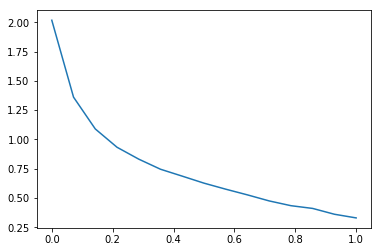

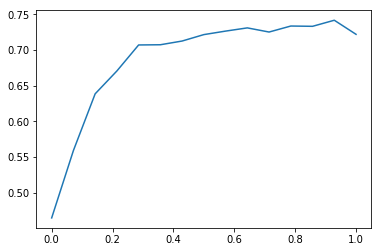

In [76]:
run(epochs=15)

[1,   200] loss: 4.614
[1,   400] loss: 4.547
[1,   600] loss: 4.316
Accuracy of the network on the test images: 0.067
[2,   200] loss: 3.987
[2,   400] loss: 3.852
[2,   600] loss: 3.716
Accuracy of the network on the test images: 0.140
[3,   200] loss: 3.512
[3,   400] loss: 3.433
[3,   600] loss: 3.411
Accuracy of the network on the test images: 0.193
[4,   200] loss: 3.218
[4,   400] loss: 3.164
[4,   600] loss: 3.139
Accuracy of the network on the test images: 0.218
[5,   200] loss: 2.985
[5,   400] loss: 2.983
[5,   600] loss: 2.962
Accuracy of the network on the test images: 0.253
[6,   200] loss: 2.845
[6,   400] loss: 2.815
[6,   600] loss: 2.812
Accuracy of the network on the test images: 0.277
[7,   200] loss: 2.640
[7,   400] loss: 2.713
[7,   600] loss: 2.704
Accuracy of the network on the test images: 0.291
[8,   200] loss: 2.534
[8,   400] loss: 2.579
[8,   600] loss: 2.602
Accuracy of the network on the test images: 0.296
[9,   200] loss: 2.425
[9,   400] loss: 2.462
[9

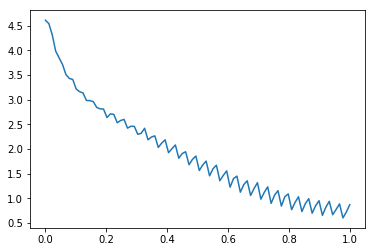

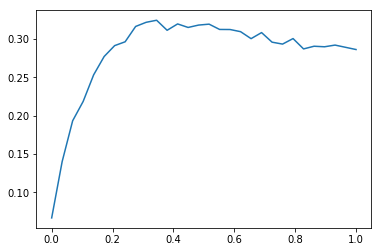

In [77]:
run("CIFAR100",30)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


[1,   200] loss: 2.486
[1,   400] loss: 0.574
Accuracy of the network on the test images: 0.838
[2,   200] loss: 0.385
[2,   400] loss: 0.363
Accuracy of the network on the test images: 0.872
[3,   200] loss: 0.323
[3,   400] loss: 0.317
Accuracy of the network on the test images: 0.879
[4,   200] loss: 0.288
[4,   400] loss: 0.290
Accuracy of the network on the test images: 0.886
[5,   200] loss: 0.261
[5,   400] loss: 0.272
Accuracy of the network on the test images: 0.894


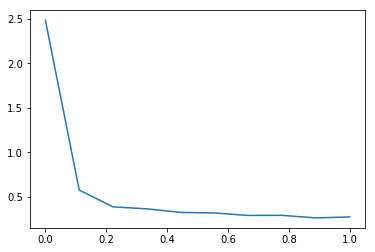

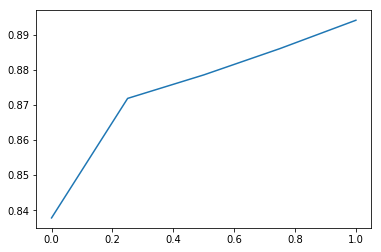

In [78]:
run("FASHION_MNIST",5)